# <center>Pipeline for Deep learning based Dose Prediction and Fluence Optimization </center>


This example showcases the core functionalities of the portpy.ai module, which is designed for deep learning-based dose prediction in the context of radiotherapy treatment planning. The main functionalities demonstrated are as follows:

1. **Data Access and Preprocessing**: The portpy.ai module allows easy access to curated portpy data, specifically tailored for training deep learning models for dose prediction. It also includes preprocessing steps to prepare the data for use in the models.

2. **Model Training and Testing**: With the portpy.ai module, users can efficiently train and test their deep learning models for dose prediction. This involves using the prepared data to create and fine-tune the models for optimal performance.

3. **Patient-Specific Dose Prediction**: The module enables the creation of personalized dose prediction for available patients in the PortPy database. This feature allows users to estimate the dose distribution for individual patients, aiding in treatment planning. Also, PortPy uses simple UNET model with MAE loss to create dose prediction. Users can implement their own customized models for better prediction and accuracy


4. **Fluence Optimization with Predicted Dose**: The predicted dose distribution can be used to optimize the fluence of radiation beams during treatment planning. The optimized fluence can be imported back to eclipse for final dose calculation. Please refer to [imrt_tps_import.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/imrt_tps_import.ipynb) for more details.

5. **Plan Visualization**: The module offers tools for visualizing treatment plans based on the predicted dose distribution. 

Overall, the portpy.ai module provides a comprehensive solution for dose prediction and treatment planning in radiotherapy, leveraging the power of deep learning and data-driven methodologies to enhance precision and patient-specific care.

In [1]:
# append portpy directory to path
import sys
sys.path.append('..')

In [3]:
import portpy.photon as pp
import SimpleITK as sitk
import os
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
from portpy.ai.preprocess.predict_using_model import predict_using_model
from portpy.ai.preprocess.data_preprocess import data_preprocess
from portpy.ai.train import train
from portpy.ai.test import test

**Note** When running it for the first time please install packages using requirements.txt 

In [8]:
# !pip install -r requirements.txt --user

### 1. Data Access and Preprocessing
![dose_prediction_pipeline](../images/dose_prediction_pipeline.png)

In [15]:
in_dir = r'../data' # directory where portpy raw data is located
out_dir = r'../ai_data' # directory where processed data to be stored for training and testing model

In [1]:
# preprocess portpy data before the training
data_preprocess(in_dir, out_dir)

**Note** split the data in train and test folder in the output directory before running further code
e.g. out_dir\train\Lung_Patient_2 out_dir\test\Lung_Patient_9

### 2. Training and testing the model

You can customize the training parameters as shown below. PortPy uses a baseline 3D U-Net architecture for model training. If desired, users can define their own architectures by modifying the networks_3d.py file located in the model directory of the portpy.ai module.
![network_arch](../images/network_arch.png)

In [6]:
# sys.argv[1:] = [] # Uncomment and run this in case if there is extra already in sys.argv of jupyter notebook

In [2]:
# Provide only the arguments you want to override
train_options = {
    "dataroot": "../ai_data",  # Directory where post-processed training/validation data is located. 
    "checkpoints_dir": "../checkpoints",  # Directory to save model checkpoints during training
    "netG": "unet_128",  # Generator architecture to use; e.g., 3D UNet with input size 128x128x128
    "name": "portpy_test_3",  # Name of the training experiment; determines subdirectory for logs and models
    "model": "doseprediction3d",  # Type of model being trained; for 3D dose prediction tasks
    "direction": "AtoB",  # Data flow direction; 'AtoB' means input (A) to predicted dose (B)
    "lambda_L1": 1,  # Weight for the L1 loss term in the total loss function
    "dataset_mode": "dosepred3d",  # Dataset class to use for loading 3D dose prediction data
    "norm": "batch",  # Type of normalization layer to use ('batch', 'instance', etc.)
    "batch_size": 1,  # Number of samples per training batch
    "pool_size": 0,  # Size of image buffer for previously generated images (0 disables the buffer)
    "display_port": 8097,  # Port to use for Visdom visualization server (if enabled)
    "lr": 0.0002,  # Initial learning rate for the optimizer
    "input_nc": 8,  # Number of input channels (e.g., CT + structure masks)
    "output_nc": 1,  # Number of output channels (e.g., predicted dose volume)
    "display_freq": 10,  # Frequency (in steps) of displaying images during training
    "print_freq": 1,  # Frequency (in steps) of printing training losses to console
    "gpu_ids": [0]  # List of GPU IDs to use; e.g., [0] for single-GPU or [0,1] for multi-GPU
}

train(train_options)  # Run training directly in Jupyter Notebook

In [ ]:
# You can uncomment and run below in case if you want to run train script from CLI
#!python ../portpy/ai/train.py --dataroot ../ai_data --netG unet_128 --name portpy_test_3 --model doseprediction3d --direction AtoB --lambda_L1 1 --dataset_mode dosepred3d --norm batch --batch_size 1 --pool_size 0 --display_port 8097 --lr 0.0002 --input_nc 8 --output_nc 1 --display_freq 10 --print_freq 1 --gpu_ids 0

Test the model

In [3]:
test_options = {
    "dataroot": "../ai_data",  # Directory where test data is located (post-processed format)
    "netG": "unet_128",  # Generator architecture to use; should match the model used during training
    "checkpoints_dir": "../checkpoints",  # Directory where trained model checkpoints are stored
    "results_dir": "../results",  # Directory to save test outputs (e.g., predicted dose volumes)
    "name": "portpy_test_3",  # Name of the experiment; used to locate the corresponding checkpoint
    "phase": "test",  # Indicates the current phase ('train', 'val', or 'test')
    "mode": "eval",  # Mode of operation; should be 'eval' to run inference
    "eval": True,  # If True, sets the model to evaluation mode (disables dropout, batch norm updates)
    "model": "doseprediction3d",  # Type of model to load; should match the training configuration
    "input_nc": 8,  # Number of input channels; must be consistent with the trained model
    "output_nc": 1,  # Number of output channels; typically 1 for dose prediction
    "direction": "AtoB",  # Data flow direction; must be consistent with training
    "dataset_mode": "dosepred3d",  # Dataset loader to use for loading test data
    "norm": "batch"  # Type of normalization used in the model; must match training setup
}

In [ ]:
# !python ../portpy/ai/test.py --dataroot ../ai_data --netG unet_128 --checkpoints_dir ../checkpoints --results_dir ../results --name portpy_test_2 --phase test --mode eval --eval --model doseprediction3d --input_nc 8 --output_nc 1 --direction Ato

### 3. Create dose prediction for the PortPy patient

After training the model, users can use their customized model to create dose prediction for any portpy patient. Below script would preprocess and predict for the patient

In [17]:
# For users who does not want to train and test, they can directly preprocess portpy data for dose predicition pipeline and predict using AI model
patient_id = 'Lung_Patient_4'
model_name = 'portpy_test_3'
pred_dose = predict_using_model(patient_id=patient_id, in_dir=in_dir, out_dir=out_dir, model_name=model_name, checkpoints_dir='../checkpoints', results_dir='../results')

Processing case Lung_Patient_4...
Creating BEV..
Loading sparse influence matrix...
Done


### 4. Fluence optimization using predicted dose

Predicted dose can then be used to create a optimal fluence. We demonstrate simple optimization can be done to create a fluence from predicted dose. The optimized fluence can be imported back to eclipse for final dose calculation. Please refer to [imrt_tps_import.ipynb](https://github.com/PortPy-Project/PortPy/blob/master/examples/imrt_tps_import.ipynb) for more details. 
Model formulation for the optimization is given below:

$
   \mbox{Minimize} \quad  ||A^{PTV}\mathbf{x}-pred^{ptv}||^2 + ||A^{oar}\mathbf{x}-pred^{oar}||^2_{+} + w_{sm}(smoothness \space objective)  
$

$
\quad \mathbf{x} \geq 0
$

Here, $\mathbf{A}$ represents the dose influence matrix, parameterizing the dose delivered to each voxel from each beamlet. $\mathbf{x}$ refers to the optimal beamlet intensities (also known as beam profiles or fluence map), while $pred$ stands for the predicted dose using the above dose prediction pipeline. The operators $||.||_{+}$  represent the positive of the input vector respectively. 

In [19]:
# load portpy data
data = pp.DataExplorer(data_dir=in_dir)
data.patient_id = patient_id
# Load ct and structure set for the above patient using CT and Structures class
ct = pp.CT(data)
structs = pp.Structures(data)

beams = pp.Beams(data)

# load clinical criteria from the config files for which plan to be optimized
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name=protocol_name)

# create rinds based upon rind definition in optimization params
protocol_name = 'Lung_2Gy_30Fx'
opt_params = data.load_config_opt_params(protocol_name=protocol_name)
# structs.create_opt_structures(opt_params)

# load influence matrix based upon beams and structure set
inf_matrix = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)

pred_dose_1d = inf_matrix.dose_3d_to_1d(dose_3d=pred_dose)

# create a plan using ct, structures, beams and influence matrix. Clinical criteria is optional
my_plan = pp.Plan(ct=ct, structs=structs, beams=beams, inf_matrix=inf_matrix, clinical_criteria=clinical_criteria)

Creating BEV..
Loading sparse influence matrix...
Done


In [20]:
# create cvxpy problem using the clinical criteria and optimization parameters
opt = pp.Optimization(my_plan, opt_params=opt_params)
# x = opt.vars['x']
A = inf_matrix.A
x = cp.Variable(A.shape[1], pos=True)
opt.vars['x'] = x
ptv_vox = inf_matrix.get_opt_voxels_idx('PTV')
opt.obj += [
    (1 / len(ptv_vox)) * cp.sum_squares(A[ptv_vox, :] @ x - pred_dose_1d[ptv_vox] / my_plan.get_num_of_fractions())]
# voxel weights for oar objectives
all_vox = np.arange(A.shape[0])
oar_voxels = all_vox[~np.isin(np.arange(A.shape[0]), ptv_vox)]
dO = cp.Variable(oar_voxels.shape[0], pos=True)
opt.constraints += [A[oar_voxels, :] @ x <= pred_dose_1d[oar_voxels] / my_plan.get_num_of_fractions() + dO]
opt.obj += [(1 / dO.shape[0]) * cp.sum_squares(dO)]

[Qx, Qy, num_rows, num_cols] = opt.get_smoothness_matrix(inf_matrix.beamlets_dict)
smoothness_X_weight = 0.6
smoothness_Y_weight = 0.4
opt.obj += [(smoothness_X_weight * (1 / num_cols) * cp.sum_squares(Qx @ x) +
            smoothness_Y_weight * (1 / num_rows) * cp.sum_squares(Qy @ x))]

sol = opt.solve(solver='MOSEK', verbose=False)
sol = {'optimal_intensity': x.value, 'inf_matrix': inf_matrix}

Running Optimization..
Optimal value: 0.005546165523223514
Elapsed time: 40.32961702346802 seconds


### 5. Plan visualization

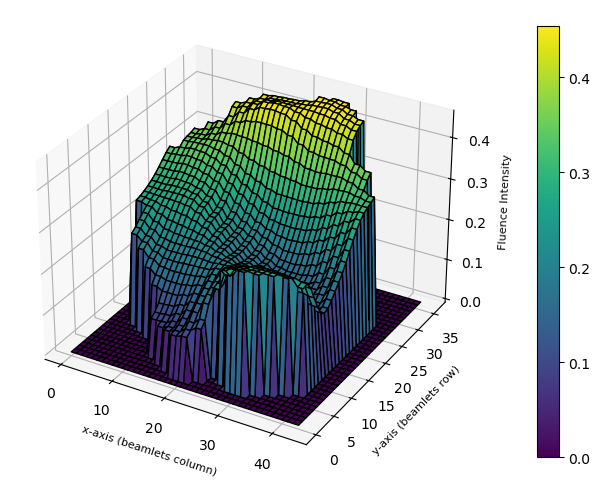

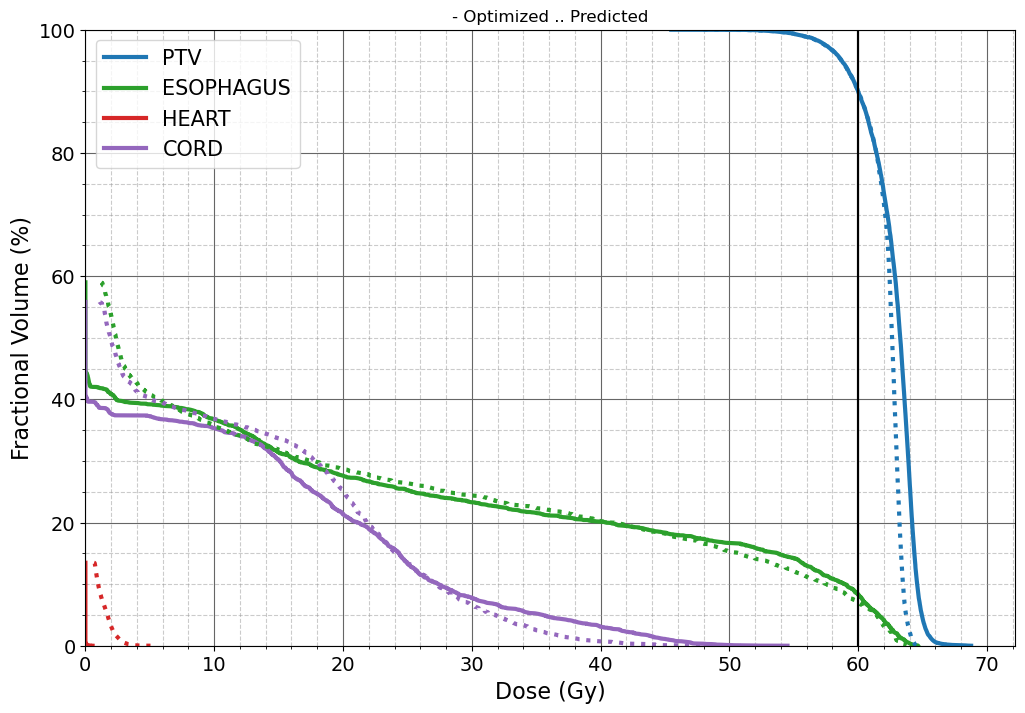

In [22]:
# plot fluence 3d and 2d for the 1st beam
pp.Visualization.plot_fluence_3d(sol=sol, beam_id=my_plan.beams.get_all_beam_ids()[0])

struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
fig, ax = plt.subplots(figsize=(12, 8))
ax = pp.Visualization.plot_dvh(my_plan, sol=sol, struct_names=struct_names, style='solid', ax=ax, norm_flag=True)
ax = pp.Visualization.plot_dvh(my_plan, dose_1d=pred_dose_1d, struct_names=struct_names, style='dotted', ax=ax,
                               norm_flag=True)
ax.set_title('- Optimized .. Predicted')
plt.show()

<Axes: title={'center': 'Axial View - Slice #: 60'}>

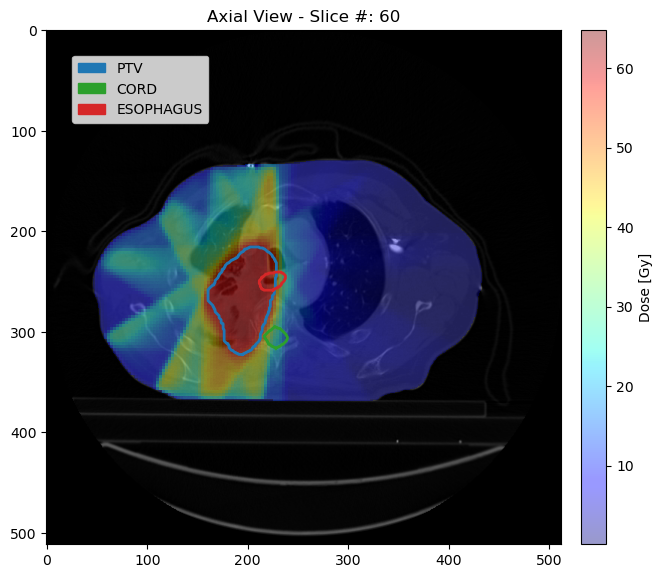

In [26]:
# Visualize 2d dose slice
pp.Visualization.plot_2d_slice(my_plan=my_plan, sol=sol, slice_num=60, struct_names=['PTV', 'CORD', 'ESOPHAGUS'])